In [2]:
pip install snntorch

     -------------------------------------- 109.0/109.0 kB 1.1 MB/s eta 0:00:00
     ---------------------------------------- 76.2/76.2 kB 2.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import snntorch as snn
import torch

In [4]:
# Training Parameters
batch_size=128
data_path='/tmp/data/mnist'
num_classes = 10  # MNIST has 10 output classes

# Torch Variables
dtype = torch.float

In [5]:
# 下载MNIST数据集
from torchvision import datasets, transforms

# 定义transform，对图像机型处理
# transforms.Resize((28,28)): 调整图像大小为28x28像素
# transforms.Grayscale(): 将图像转换为灰度图像
# transforms.ToTensor(): 将图像转换为PyTorch张量
# transforms.Normalize((0,), (1,)): 对图像进行标准化，将像素值从范围[0, 1]缩放到均值为0，标准差为1的范围。
transform = transforms.Compose([
            transforms.Resize((28,28)), 
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /tmp/data/mnist\MNIST\raw\train-images-idx3-ubyte.gz to /tmp/data/mnist\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /tmp/data/mnist\MNIST\raw\train-labels-idx1-ubyte.gz to /tmp/data/mnist\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /tmp/data/mnist\MNIST\raw\t10k-images-idx3-ubyte.gz to /tmp/data/mnist\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /tmp/data/mnist\MNIST\raw\t10k-labels-idx1-ubyte.gz to /tmp/data/mnist\MNIST\raw



In [12]:
mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)


In [13]:
from snntorch import utils

subset = 10
mnist_train = utils.data_subset(mnist_train, subset)
print(f"The size of mnist_train is {len(mnist_train)}")

The size of mnist_train is 12000


In [19]:
# 可以将编码理解为伯努利分布。下面对伯努利进行实验。
# 也可以将其理解为大数定理。
num_steps = 100

# create vector filled with 0.5
raw_vector = torch.ones(num_steps)*0.5

# pass each sample through a Bernoulli trial
rate_coded_vector = torch.bernoulli(raw_vector)
print(f"Converted vector: {rate_coded_vector}")
print(raw_vector)
print(f"The output is spiking {rate_coded_vector.sum()*100/len(rate_coded_vector):.2f}% of the time.")

Converted vector: tensor([0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0.,
        0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
        1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0.,
        0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1.,
        1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0.,
        1., 1., 0., 0., 0., 0., 0., 0., 1., 1.])
tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.500

In [23]:
# 尖峰编码
# 将输入转换为序列长度 的尖峰序列 num_steps，其中每个特征/像素均采用离散值{0，1} 
# 在这种情况下，MNIST 被转换为随时间变化的尖峰序列，其特征在于与原始图像的关系。
# snntorch.spikegen（即尖峰生成）包含一系列函数，可简化数据到尖峰的转换。
# 速率编码： spikegen.rate；延迟编码： spikegen.latency；增量调制： spikegen.delta
from snntorch import spikegen
# 批处理数据
from torch.utils.data import DataLoader 

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

# Iterate through minibatches
data = iter(train_loader)
data_it, targets_it = next(data)

# Spiking Data
spike_data = spikegen.rate(data_it, num_steps=num_steps)
# 第一个维度（100）：表示批次大小（Batch Size），即张量中包含了 100 个样本。
# 第二个维度（128）：表示每个批次中有 128 个通道或特征图
# 第三个维度（1）：表示每个通道中包含 1 个单通道图像。这可能是灰度图像，因为只有一个通道。
# 第四个维度（28）：表示图像的高度，为 28 像素。
# 第五个维度（28）：表示图像的宽度，为 28 像素。

print(spike_data.size())


torch.Size([100, 128, 1, 28, 28])


The corresponding target is: 1


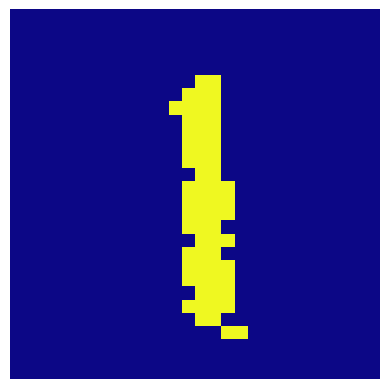

In [28]:
# 编码可视化
# snnTorch 包含一个模块 snntorch.spikeplot ，它简化了尖峰神经元的可视化、绘图和动画处理过程。
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

spike_data_sample = spike_data[:, 0, 0]
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample, fig, ax)
plt.rcParams['animation.ffmpeg_path'] = 'D:\\ffmpeg\\ffmpeg-2024-01-14-git-34a47b97de-essentials_build\\bin\\ffmpeg.exe'

HTML(anim.to_html5_video())
print(f"The corresponding target is: {targets_it[0]}")

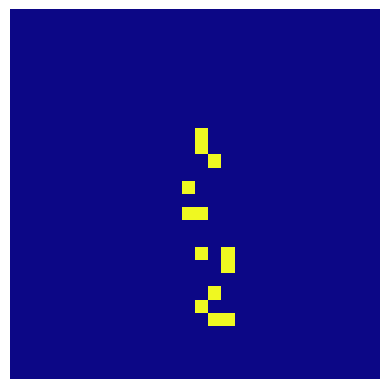

In [30]:
# gain=0.25：我们将尖峰频率降低至 25%。

spike_data = spikegen.rate(data_it, num_steps=num_steps, gain=0.25)

spike_data_sample2 = spike_data[:, 0, 0]
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample2, fig, ax)
HTML(anim.to_html5_video())

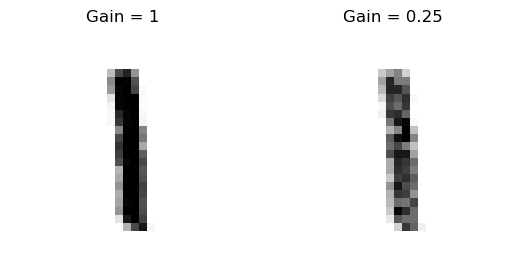

In [31]:
plt.figure(facecolor="w")
plt.subplot(1,2,1)
plt.imshow(spike_data_sample.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary')
plt.axis('off')
plt.title('Gain = 1')

plt.subplot(1,2,2)
plt.imshow(spike_data_sample2.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary')
plt.axis('off')
plt.title('Gain = 0.25')

plt.show()

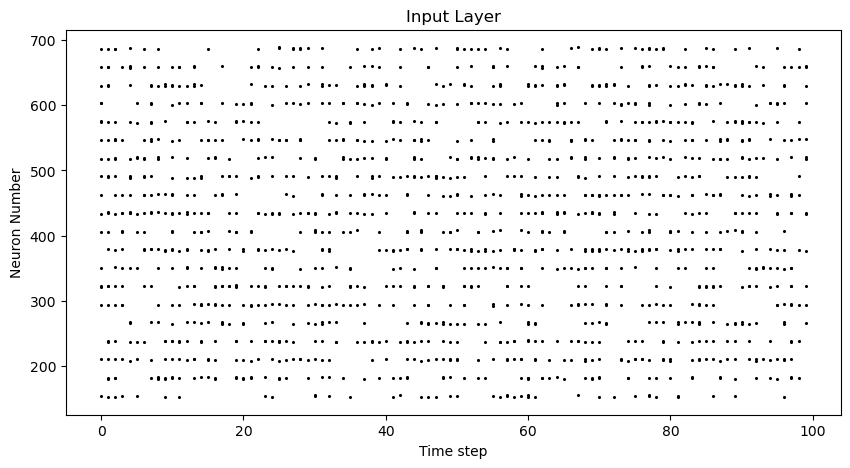

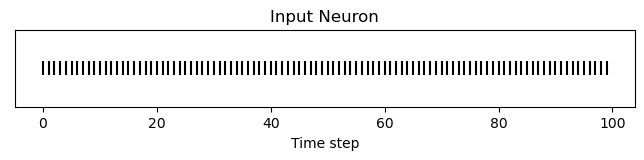

In [32]:
# 光栅图：光栅图（Raster Plot）是神经科学和计算神经科学中常
# 用的一种图形表示方法，用于可视化神经元或群体的脉冲（动作电位）活动。
# 这种图形显示了神经元在时间上的活动模式，每一行代表一个神经元，每一列代表一个时间步。
# Reshape
spike_data_sample2 = spike_data_sample2.reshape((num_steps, -1))

# raster plot
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data_sample2, ax, s=1.5, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

idx = 210  # index into 210th neuron

fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

splt.raster(spike_data_sample.reshape(num_steps, -1)[:, idx].unsqueeze(1), ax, s=100, c="black", marker="|")

plt.title("Input Neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.show()

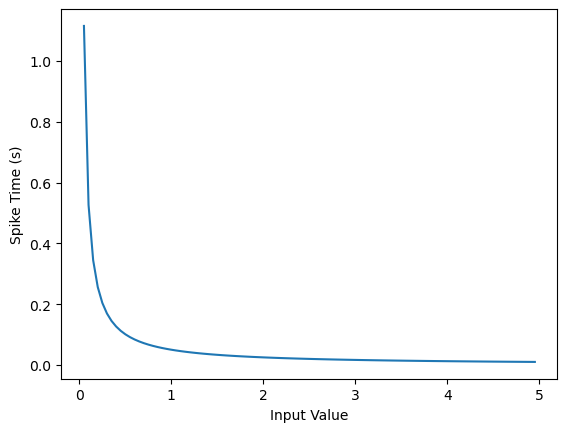

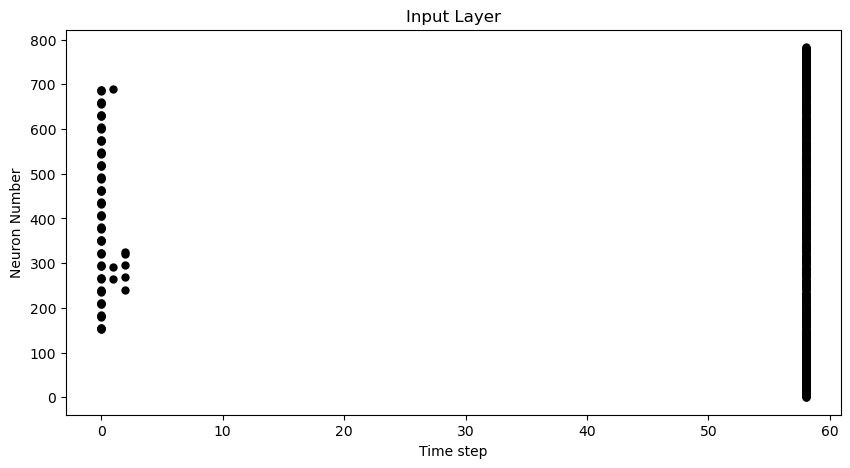

In [33]:
# 延迟编码
def convert_to_time(data, tau=5, threshold=0.01):
  spike_time = tau * torch.log(data / (data - threshold))
  return spike_time

raw_input = torch.arange(0, 5, 0.05) # tensor from 0 to 5
spike_times = convert_to_time(raw_input)

plt.plot(raw_input, spike_times)
plt.xlabel('Input Value')
plt.ylabel('Spike Time (s)')
plt.show()

spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01)


fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()


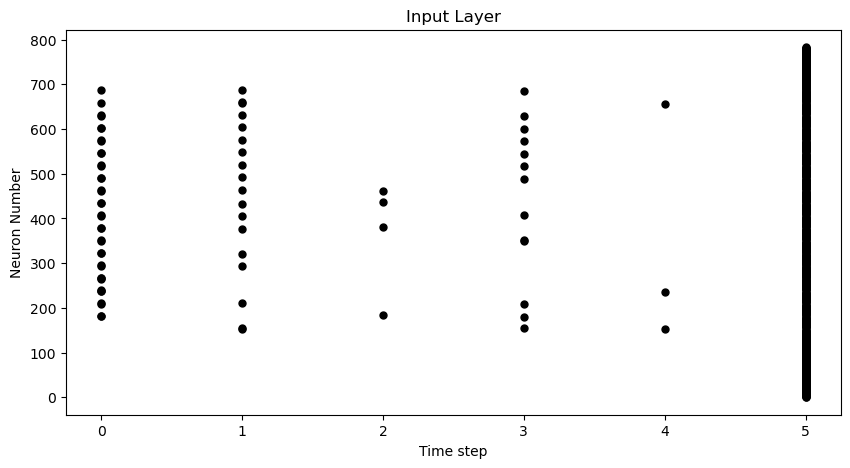

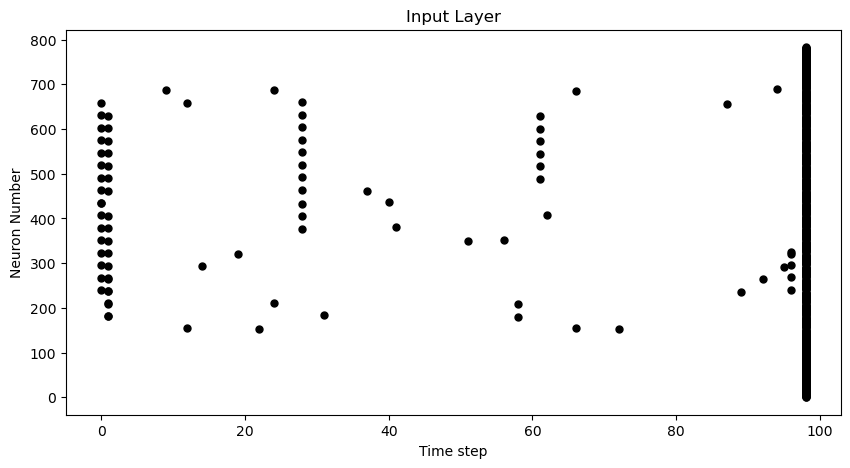

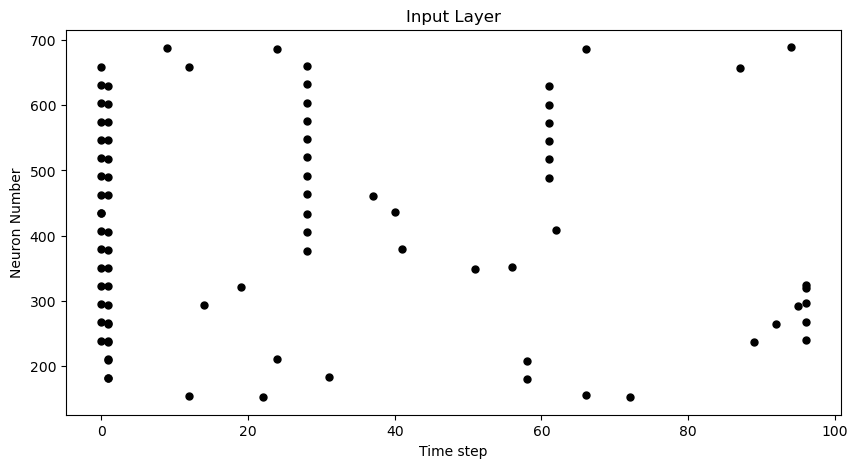

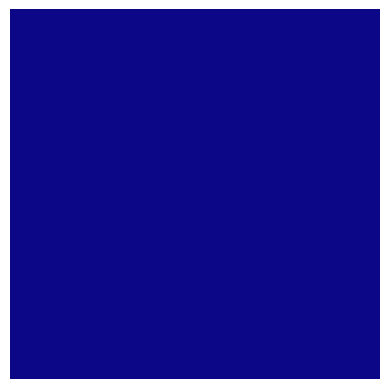

In [34]:
# 对数代码加上缺乏不同的输入值（即缺乏中间色调/灰度特征）会导致绘图的两个区域出现
# 显着的聚类。亮像素在运行开始时引起放电，暗像素在运行结束时引起放电。我们可以增加
# tau以减慢尖峰时间，或者通过设置可选参数来线性化尖峰时间linear=True。

spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01, linear=True)

fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")
plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01,
                              normalize=True, linear=True)

fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()


spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01,
                              clip=True, normalize=True, linear=True)

fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()
spike_data_sample = spike_data[:, 0, 0]

fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample, fig, ax)

HTML(anim.to_html5_video())

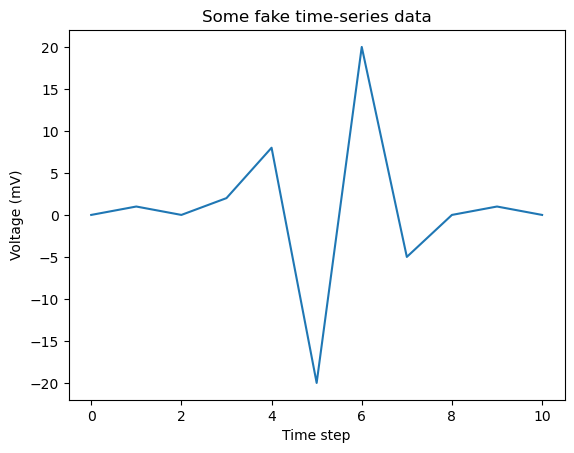

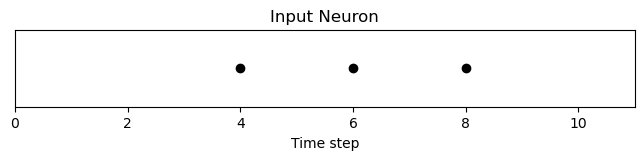

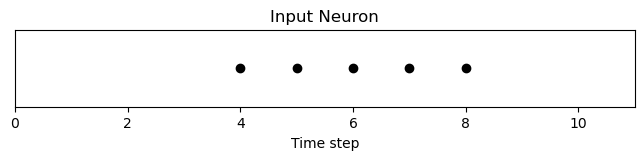

In [35]:
# 增量调制
# Create a tensor with some fake time-series data
data = torch.Tensor([0, 1, 0, 2, 8, -20, 20, -5, 0, 1, 0])

# Plot the tensor
plt.plot(data)

plt.title("Some fake time-series data")
plt.xlabel("Time step")
plt.ylabel("Voltage (mV)")
plt.show()

# Convert data
spike_data = spikegen.delta(data, threshold=4)

# Create fig, ax
fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

# Raster plot of delta converted data
splt.raster(spike_data, ax, c="black")

plt.title("Input Neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.xlim(0, len(data))
plt.show()

# Convert data
spike_data = spikegen.delta(data, threshold=4, off_spike=True)

# Create fig, ax
fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

# Raster plot of delta converted data
splt.raster(spike_data, ax, c="black")

plt.title("Input Neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.xlim(0, len(data))
plt.show()

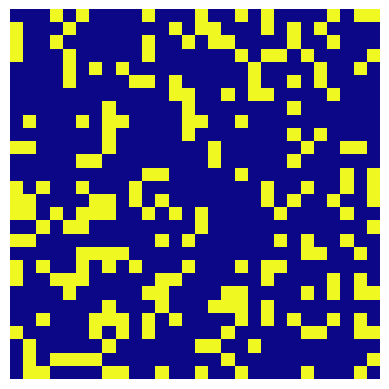

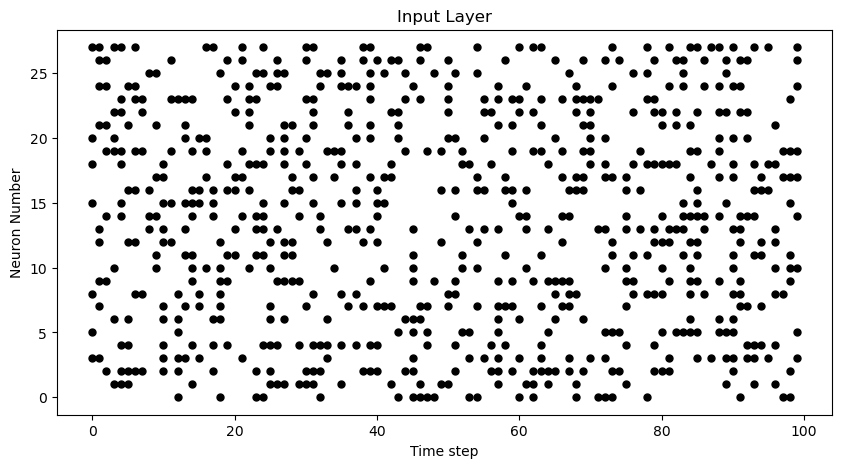

In [36]:
# 现在，如果我们实际上没有任何数据可以开始怎么办？
# 假设我们只想从头开始随机生成一个尖峰序列。
# Create a random spike train
spike_prob = torch.rand((num_steps, 28, 28), dtype=dtype) * 0.5
spike_rand = spikegen.rate_conv(spike_prob)
fig, ax = plt.subplots()
anim = splt.animator(spike_rand, fig, ax)

HTML(anim.to_html5_video())

fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_rand[:, 0].view(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()